### Budget allocation proposal

This notebook holds the data analysis and text for the budget allocation problem, exemplifying a few concepts as well as doing basic analysis of invested cost and yielded sessions & revenue.

In [63]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

validDf = pd.read_csv("../data/valid_dataset_minimal.csv")
campaigns = validDf["Campaign"].unique()
validDf["Date"] = pd.to_datetime(validDf["Date"])

print(validDf.head(10))

   Unnamed: 0       Date   Cost  Revenue Medium  \
0          93 2018-02-26   8.47     0.00    cpc   
1          94 2018-02-26   0.68     0.00    cpc   
2          95 2018-02-26   0.01     0.00    cpc   
3          96 2018-02-26   0.22     0.00    cpc   
4          97 2018-02-26  77.49     0.00    cpc   
5          98 2018-02-26  17.89     0.00    cpc   
6          99 2018-02-26   2.94     0.00    cpc   
7         101 2018-02-27  12.14    96.94    cpc   
8         102 2018-02-27   0.93     0.00    cpc   
9         103 2018-02-27   1.09     0.00    cpc   

                                            Campaign  Sessions  
0                                   AW - Accessories        38  
1                                   AW - Accessories        13  
2                                   AW - Accessories         1  
3                                       AW - Apparel         1  
4  1000557 | GA | US | en | Hybrid | GDN Remarketing        24  
5  1000557 | GA | US | en | Hybrid | GDN Remarke

### 1. Recap

Let's start with a plot from the first notebook, where, for each valid campaign, I plot the daily cost, number of sessions and revenue.

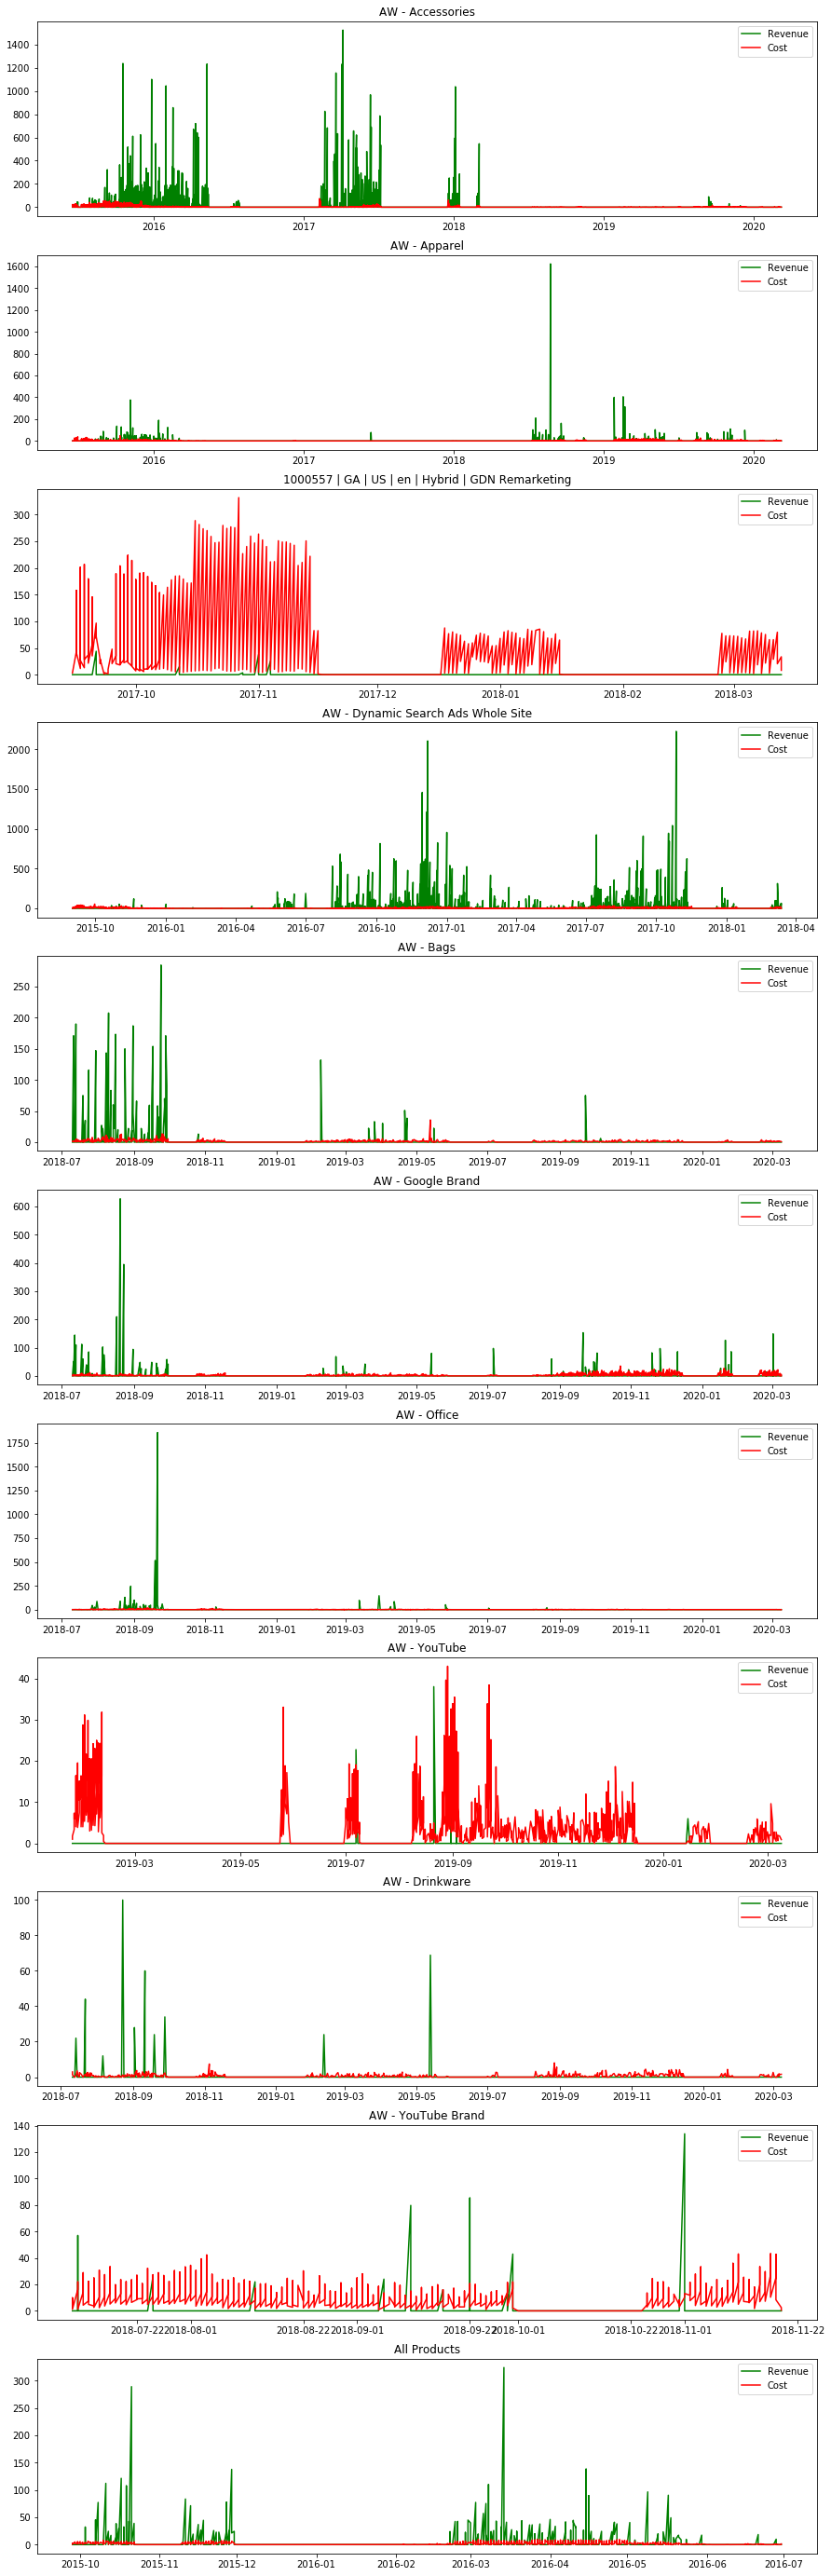

In [2]:
# Do a list of all dates between earliest and latest
nRows = len(campaigns)
ax = plt.subplots(nRows, figsize=(15, 50))[1]

for i, campaign in enumerate(campaigns):
    dfRelevant = validDf[validDf["Campaign"] == campaign]
    dateRange = pd.DataFrame({
        "Date" : pd.date_range(dfRelevant["Date"].min(), dfRelevant["Date"].max(), freq="D"),
    })
    # Fill missing months by zeros
    dfRelevant = dateRange.set_index("Date").join(dfRelevant.set_index("Date")).fillna(0).reset_index()

    ax[i].plot(dfRelevant["Date"], dfRelevant["Revenue"], color="green")
    ax[i].plot(dfRelevant["Date"], dfRelevant["Cost"], color="red")
    ax[i].set_title(campaign)
    ax[i].legend(["Revenue", "Cost"])

We see that, each campaign has some investment, and then that investment yields some user sessions and some revenue. However, we have no idea what investment is correlated to what change in revenue. The data only tells us daily information: how much we invested today

### 2. First-revenue assumption

#### 2.1 Dataset creation

Let's start with the campaign "All Products", a it seems that there are a lot of revenues there. (TO update to all)

In [56]:
def getDataFirstRevenue(allDf, campaign):
    df = allDf.loc[allDf["Campaign"] == campaign].reset_index()[["Date", "Cost", "Revenue"]]
#     print("Df shape:", df.shape)

    tmpRevenues = df.loc[df["Revenue"] > 0, "Revenue"].to_numpy()
#     print("How many items have revenue", len(tmpRevenues))

    costs, revenues = [], []
    indexesL, indexesR = np.array([0, *tmpRevenues[0 : -1]]), tmpRevenues
    nRows = len(indexesL)
    tmpRevenue = 0
    for i in range(nRows):
        tmpRevenue += tmpRevenues[i]
        indexLeft, indexRight = indexesL[i], indexesR[i]
        items = df.loc[(df.index >= indexLeft) & (df.index < indexRight), "Cost"]
        sumCosts = items.sum()

        # Consecutive revenues may also have cost of 0 between them, so we skip those and sum the revenues
        if sumCosts > 0:
            costs.append(items.to_numpy())
            revenues.append(tmpRevenue)
            tmpRevenue = 0
#     print("Costs and revenues count: %d" % (len(costs)))
    return costs, revenues

data = {}
for campaign in campaigns:
    costs, revenues = getDataFirstRevenue(validDf, campaign)
    if len(costs) < 20:
        continue
    print("Campaign: %s. Num items: %d" % (campaign, len(costs)))
    data[campaign] = np.array([costs, revenues]).T
validCampaigns = list(data.keys())

Campaign: AW - Accessories. Num items: 239
Campaign: AW - Apparel. Num items: 72
Campaign: AW - Dynamic Search Ads Whole Site. Num items: 182
Campaign: AW - Bags. Num items: 25
Campaign: AW - Google Brand. Num items: 27
Campaign: All Products. Num items: 55


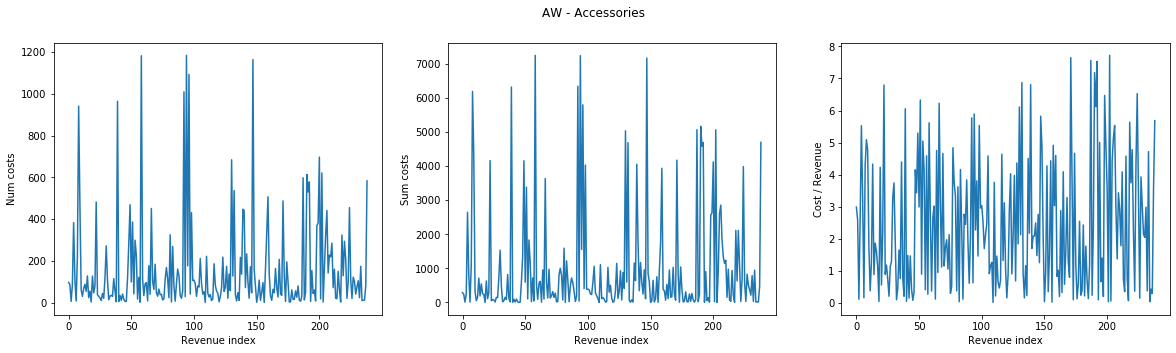

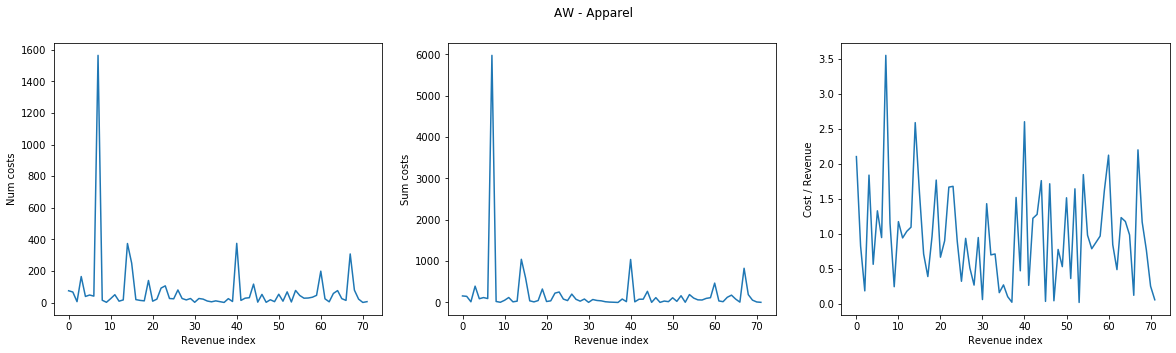

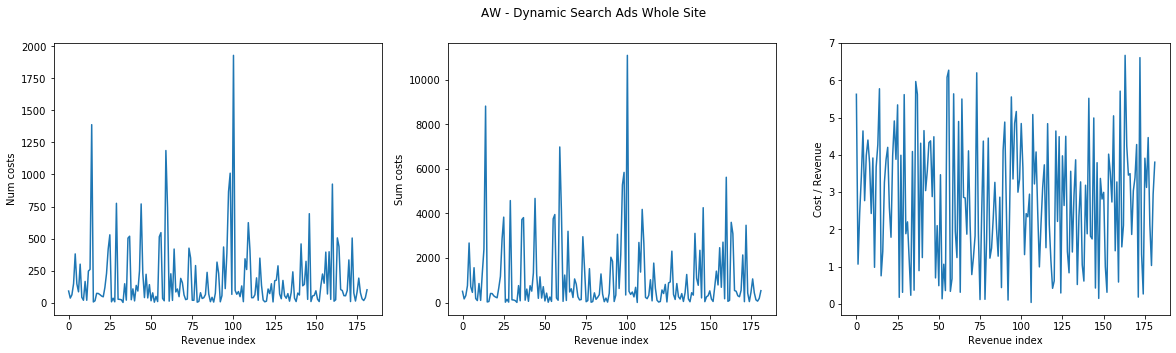

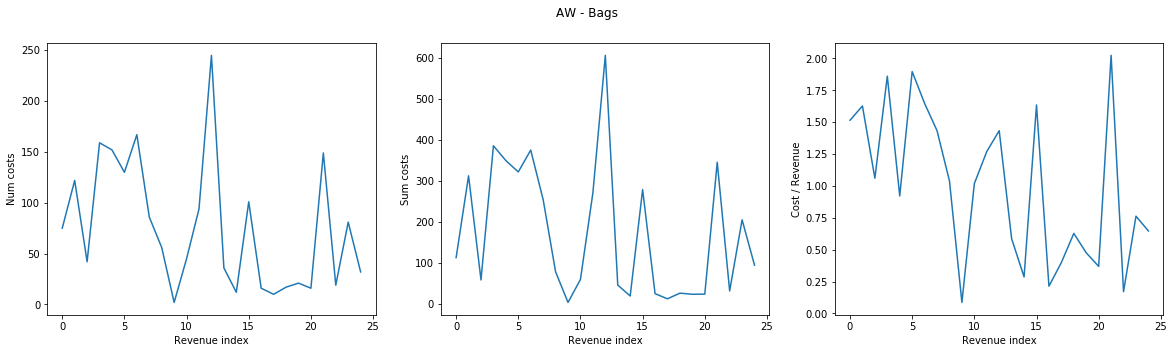

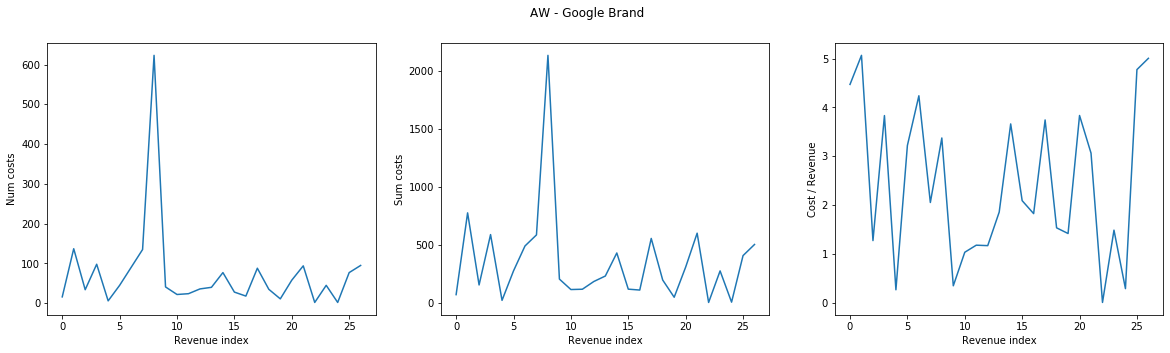

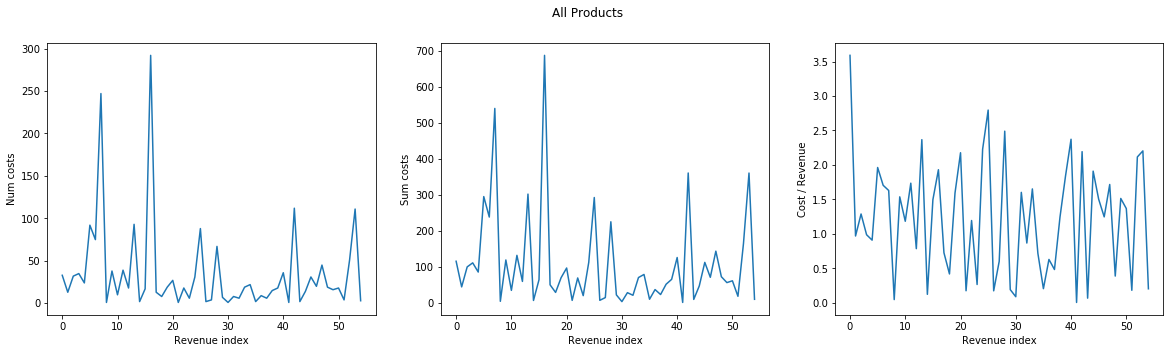

In [57]:
for campaign in validCampaigns:
    costs, revenues = data[campaign].T
    ax = plt.subplots(1, 3, figsize=(20, 5))[1]
    numCosts = np.array([len(x) for x in costs])
    ax[0].plot(range(len(numCosts)), numCosts)
    ax[0].set_xlabel("Revenue index")
    ax[0].set_ylabel("Num costs")

    sumCosts = np.array([sum(x) for x in costs])
    ax[1].plot(range(len(numCosts)), sumCosts)
    ax[1].set_xlabel("Revenue index")
    ax[1].set_ylabel("Sum costs")

    rapp = np.array([sum(x)/y for x, y in zip(costs, revenues)])
    ax[2].plot(range(len(rapp)), rapp)
    ax[2].set_xlabel("Revenue index")
    ax[2].set_ylabel("Cost / Revenue")
    
    plt.gcf().suptitle(campaign)

#### 2.2 Statistical model (Notebook 2)

In [155]:
class StatisticalModel:
    def __init__(self):
        # This model has just a single parameter, computed as the count between targets and inputs
        self.param = np.nan
        
    def fit(self, x, t):
        assert self.param != self.param
        self.param = t.sum() / x.sum()
    
    def predict(self, x):
        assert self.param == self.param
        return x * self.param

class KFold:
    def __init__(self, numSplits, randomState):
        self.randomState = randomState
        assert numSplits > 0
        self.numSplits = numSplits
    
    def split(self, numData):
        np.random.seed(self.randomState)
        perm = np.random.permutation(numData)
        n = numData // self.numSplits
        for i in range(self.numSplits):
            trainIx = list(range(0, i * n)) + list(range((i + 1) * n, numData))
            valIx = list(range(i * n, (i + 1) * n))
            yield perm[trainIx], perm[valIx]

def errorL1(y, t):
    return np.abs(y - t).mean()

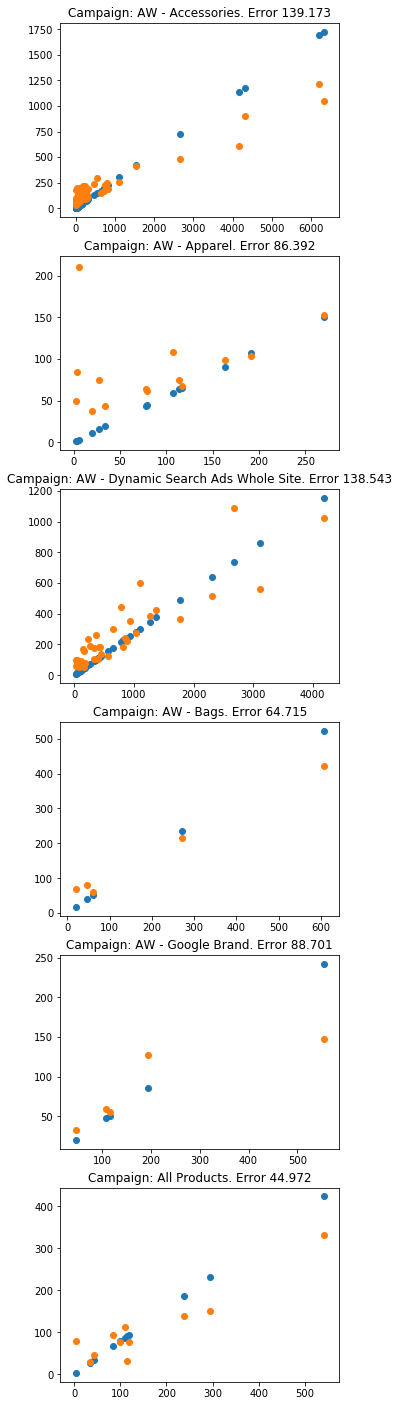

In [163]:
def trainStatisticalModel(X, t):
    models, errors, predictions = [], [], []
    for trainIx, validationIx in kf.split(len(X)):
        _X = {"train" : X[trainIx], "validation" : X[validationIx]}
        _t = {"train" : t[trainIx], "validation" : t[validationIx]}
        model = StatisticalModel()
        model.fit(_X["train"], _t["train"])
        y = model.predict(_X["validation"])
        errors.append(errorL1(y, _t["validation"]))
        models.append(model)
        predictions.append({"X" : _X["validation"], "y" : y, "t" : _t["validation"]})
    meanError = np.mean(errors)
    bestPredictions = predictions[np.argmin(errors)]
    
    # Retrain on all data
    model = StatisticalModel()
    model.fit(X, t)
    return model, bestPredictions, meanError

models = {}
X, t = {k : data[k].T[0] for k in data}, {k : data[k].T[1] for k in data}
# For statistical model, sum all intermediate costs
XStatisticalModel = {k : np.array([x.sum() for x in X[k]]) for k in X}
ax = plt.subplots(len(validCampaigns), figsize=(5, 25))[1]
for i, campaign in enumerate(validCampaigns):
    models[campaign], predictions, error = trainStatisticalModel(XStatisticalModel[campaign], t[campaign])
    ax[i].scatter(predictions["X"], predictions["y"])
    ax[i].scatter(predictions["X"], predictions["t"])
    ax[i].set_title("Campaign: %s. Error %2.3f" % (campaign, error))

#### 2.3 Create pseudo-revenues for all costs

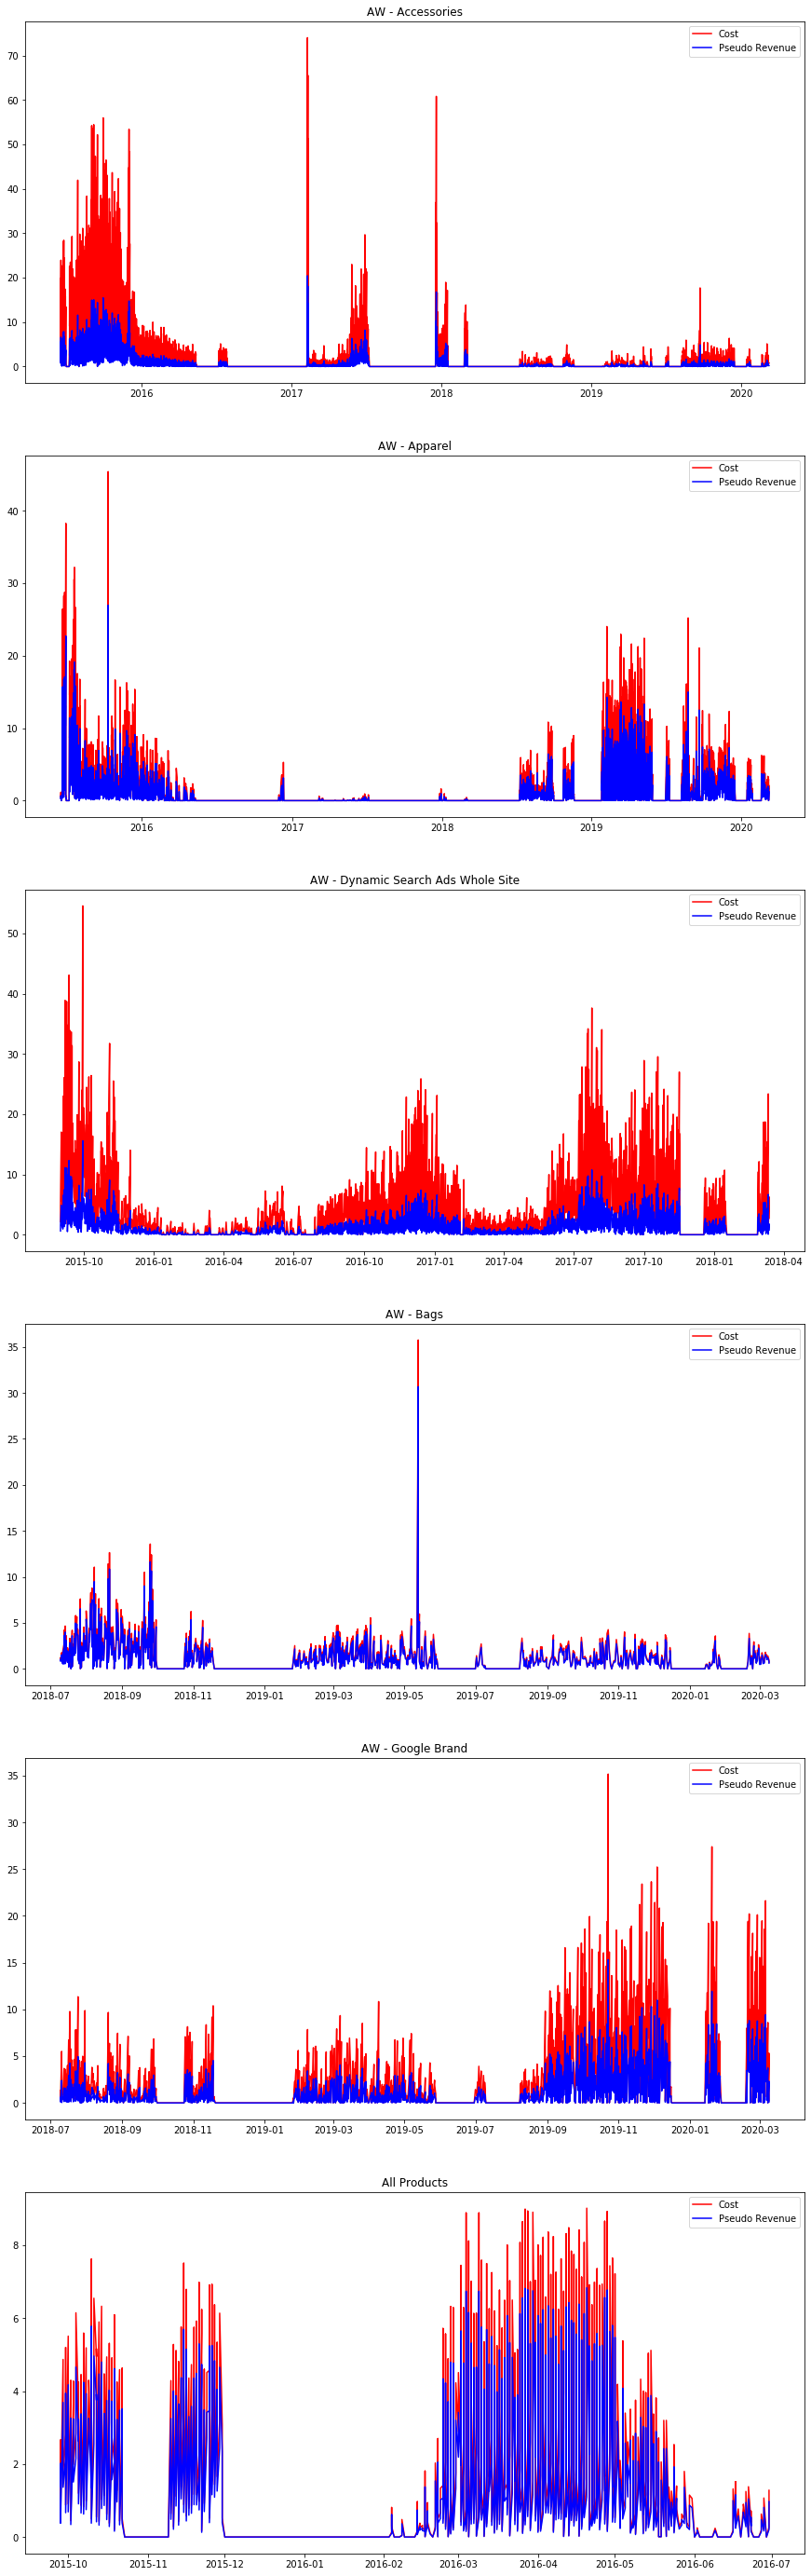

In [191]:

nRows = len(validCampaigns)
ax = plt.subplots(nRows, figsize=(15, 50))[1]

for i, campaign in enumerate(validCampaigns):
    dfRelevant = validDf[validDf["Campaign"] == campaign]
    dateRange = pd.DataFrame({
        "Date" : pd.date_range(dfRelevant["Date"].min(), dfRelevant["Date"].max(), freq="D"),
    })
    # Fill missing months by zeros
    dfRelevant = dateRange.set_index("Date").join(dfRelevant.set_index("Date")).fillna(0).reset_index()
    dfRelevant["Pseudo Revenue"] = models[campaign].predict(dfRelevant["Cost"])

#     ax[i].plot(dfRelevant["Date"], dfRelevant["Revenue"], color="green")
    ax[i].plot(dfRelevant["Date"], dfRelevant["Cost"], color="red")
    ax[i].plot(dfRelevant["Date"], dfRelevant["Pseudo Revenue"], color="blue")
    ax[i].set_title(campaign)
    ax[i].legend(["Cost", "Pseudo Revenue"])